<a href="https://colab.research.google.com/github/Thabhelo/traffi-density-classification/blob/main/Traffic_Density_Classification_with_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Overview
This dataset consists of images collected from the open-source API provided by Singapore's Land Transport Authority (LTA). The images are categorized into five traffic density levels: Empty, Low, Medium, High, and Traffic Jam. Out of 87 available traffic cameras, 20 were selected based on their ability to capture diverse and relevant images. Selection criteria included variability in traffic density, different lighting conditions, clear visibility (without obstructions), and suitable camera angles. A total of 4,054 images were manually labeled and then randomly divided into subsets: 80% for training, 10% for validation, and 10% for testing. To enhance robustness, the dataset includes images captured during both daytime and nighttime.

In [ ]:
!pip install albumentations torch torchvision

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Check to confirm we are using A 100 GPU instead of CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Imports

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0
from torchvision.models import EfficientNet_B0_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_style("darkgrid")

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

# Configuration

In [ ]:
train_dir = "/content/traffic_density/Final Dataset/training"
val_dir = "/content/traffic_density/Final Dataset/validation"
test_dir = "/content/traffic_density/Final Dataset/testing"

classes=['Empty', 'High', 'Low', 'Medium', 'Traffic Jam']

batch_size=8
device="cuda"

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Exploratory data Analysis

In [ ]:
!unzip traffic-density-singapore.zip -d /content/traffic_density

Archive:  traffic-density-singapore.zip
  inflating: /content/traffic_density/Final Dataset/testing/Empty/00a2d16e-742e-469f-a23a-631ad49ec790.jpg  
  inflating: /content/traffic_density/Final Dataset/testing/Empty/01d0f221-a94d-44ce-ba07-462f2f46f62c.jpg  
  inflating: /content/traffic_density/Final Dataset/testing/Empty/02bbbe52-297c-4eed-aac2-de40ad6bd0b8.jpg  
  inflating: /content/traffic_density/Final Dataset/testing/Empty/0a175e12-bade-49c4-ad00-c07329ce5fd4.jpg  
  inflating: /content/traffic_density/Final Dataset/testing/Empty/0a37454f-40c2-4302-9e8b-23af7b95875b.jpg  
  inflating: /content/traffic_density/Final Dataset/testing/Empty/0a7b874b-20dd-4ab2-b2ed-89645e4c20bc.jpg  
  inflating: /content/traffic_density/Final Dataset/testing/Empty/0a86cfa7-7b99-4ce7-8da8-42c51d2eafff.jpg  
  inflating: /content/traffic_density/Final Dataset/testing/Empty/0aad5c2c-a166-416a-9d6d-3e5da232a5ae.jpg  
  inflating: /content/traffic_density/Final Dataset/testing/Empty/0acd3ef9-fa98-4e37-aca

In [ ]:
directories=[train_dir,val_dir,test_dir]
img_shapes=[]

for i,directory in enumerate(directories):
    for density_dir_name in os.listdir(directory):
        density_dir_path=os.path.join(directory,density_dir_name)
        for img_file_name in os.listdir(density_dir_path):
            img_path=os.path.join(density_dir_path,img_file_name)
            img=cv2.imread(img_path)
            img_shapes.append([img.shape[0],img.shape[1],directory.split("/")[-1]])

img_shape_data=pd.DataFrame(data=img_shapes,columns=["height","width","split"])

In [ ]:
img_shape_data.groupby("split")[["height","width"]].describe().T

split             testing     training   validation
height count   320.000000  3378.000000   340.000000
       mean    411.093750   402.775311   399.158824
       std     106.509852    99.681314    82.614208
       min     119.000000   130.000000   163.000000
       25%     360.000000   360.000000   360.000000
       50%     360.000000   360.000000   360.000000
       75%     480.000000   480.000000   480.000000
       max    1252.000000  2832.000000   800.000000
width  count   320.000000  3378.000000   340.000000
       mean    626.071875   609.701599   615.964706
       std     146.682642   134.039099    97.736651
       min     111.000000   250.000000   275.000000
       25%     640.000000   640.000000   640.000000
       50%     640.000000   640.000000   640.000000
       75%     640.000000   640.000000   640.000000
       max    1920.000000  4256.000000  1200.000000

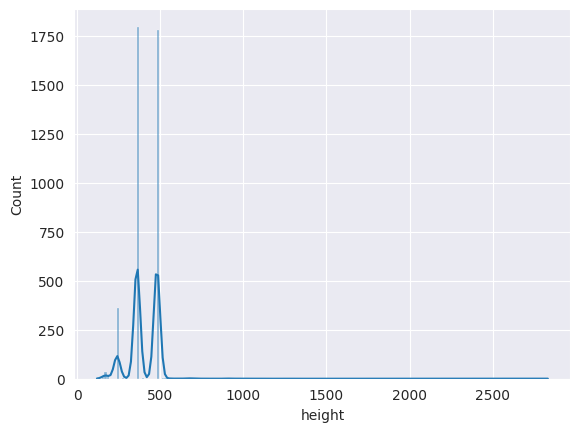

In [ ]:
sns.histplot(img_shape_data["height"],kde=True);

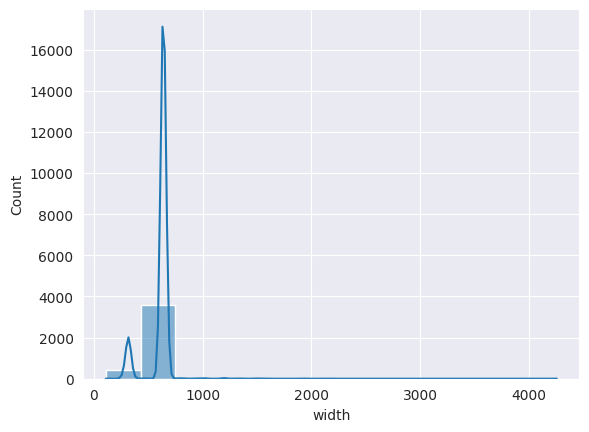

In [ ]:
sns.histplot(img_shape_data["width"],kde=True);

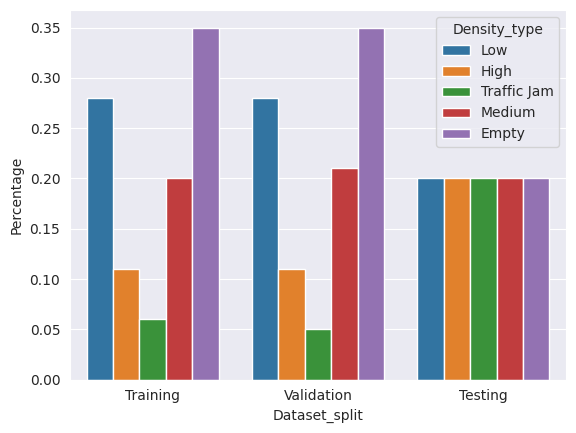

In [ ]:
directories=[train_dir,val_dir,test_dir]
total_instances=[3378,340,320]
instances_list=[]
for i,directory in enumerate(directories):
    for density_dir_name in os.listdir(directory):
        density_dir_path=os.path.join(directory,density_dir_name)
        instances=round(len(os.listdir(density_dir_path))/total_instances[i],2)
        instances_list.append([directory.split("/")[-1].capitalize(),density_dir_name,
                               instances])

inter=pd.DataFrame(data=instances_list,columns=["Dataset_split","Density_type","Percentage"])
sns.barplot(data=inter,x="Dataset_split",y="Percentage",hue="Density_type");

# Image Augmentation

In [ ]:
train_transform=A.Compose([A.HorizontalFlip(),
                           A.ShiftScaleRotate(rotate_limit=5,value=0,
                                              border_mode=cv2.BORDER_CONSTANT),

                           A.OneOf(
                                   [A.CLAHE(),
                                    A.RandomBrightnessContrast(),
                                    A.HueSaturationValue()],p=1),
                           A.GaussNoise(),
                           A.RandomResizedCrop(height=400,width=600),
                           A.Normalize(),
                           ToTensorV2()])

val_transform=A.Compose([A.Resize(height=400,width=600),
                         A.Normalize(),
                         ToTensorV2()])

In [ ]:
def open_img(img_path):
    img=Image.open(img_path)
    img=np.array(img)
    if img.shape[2]==3:
        return img
    else:
        return img[:,:,:-1]

class Transform():
    def __init__(self,transform):
        self.transform=transform
    def __call__(self,image):
        return self.transform(image=image)["image"]

# Dataset

In [ ]:
train_ds=ImageFolder(train_dir,transform=Transform(train_transform),loader=open_img)
val_ds=ImageFolder(val_dir,transform=Transform(val_transform),loader=open_img)
test_ds=ImageFolder(test_dir,transform=Transform(val_transform),loader=open_img)

In [ ]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    pin_memory=True if device is "cuda" else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  pin_memory=True if device is "cuda" else False)
test_dl=DataLoader(test_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                   pin_memory=True if device is "cuda" else False)

# Data Visualization

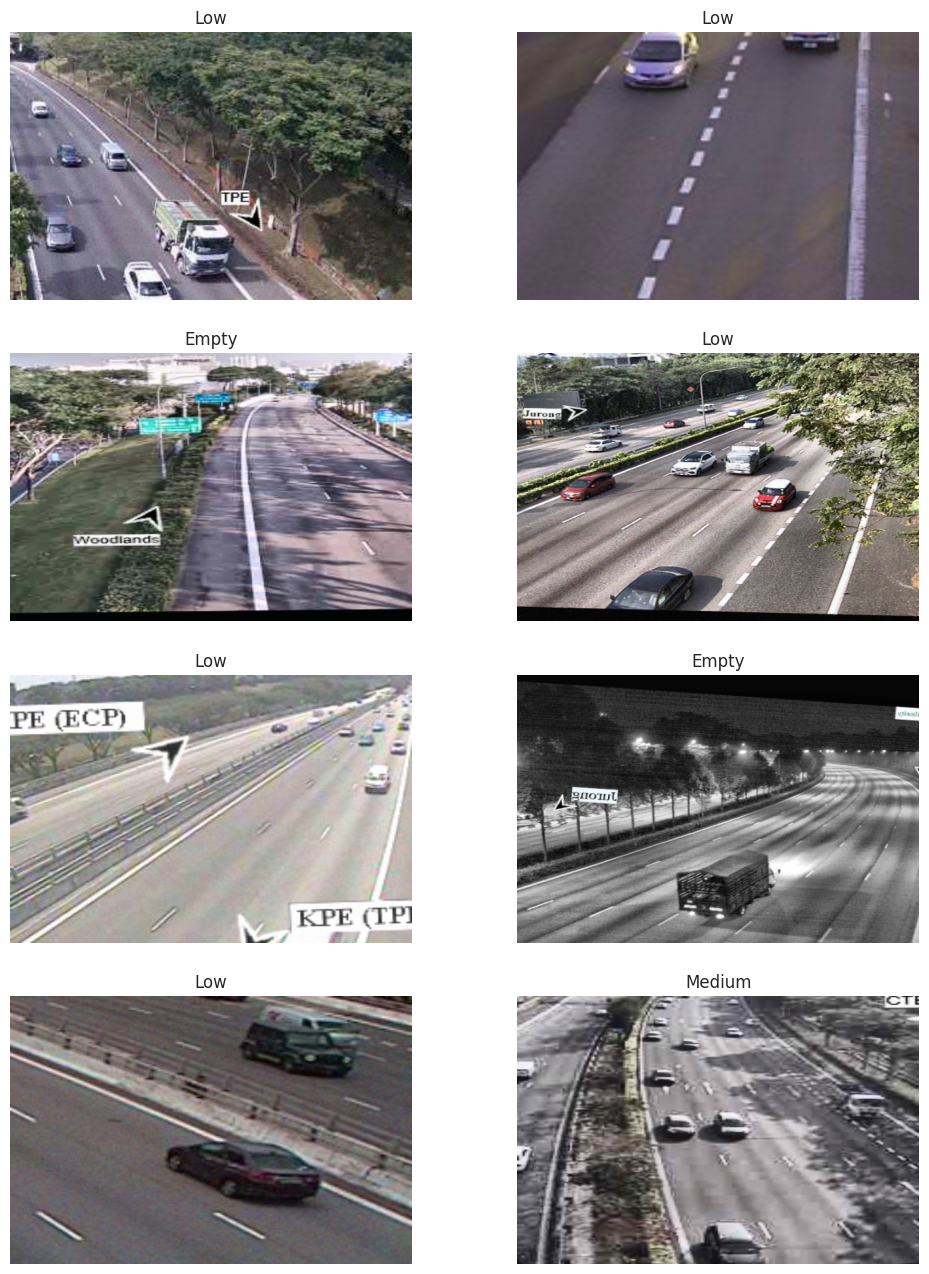

In [ ]:
fig,axes=plt.subplots(4,2,figsize=(12,16))
ax=axes.flatten()
imgs,labels=next(iter(train_dl))


for i,img in enumerate(imgs):
    imgp=np.transpose(img.numpy().copy(),(1,2,0))*std+mean
    ax[i].imshow(imgp)
    ax[i].set_title(classes[labels[i].item()])
    ax[i].axis("off")

# Training

In [ ]:
def get_lr(optimizer):
    # Retrieves the current learning rate from the optimizer
    for params in optimizer.param_groups:
        return params["lr"]

def training(model, epochs, train_dl, val_dl, optimizer, lr_scheduler, loss_fn, weights_path):
    best_val_acc = 0.0  # Tracks best validation accuracy
    patience = 10  # Optional: could be used for early stopping (not used here)
    best_weights = copy.deepcopy(model.state_dict())  # Save initial model weights
    loss_dict = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}  # Log losses and accuracies

    # Loop over epochs
    for epoch in range(epochs):
        train_loss = 0.0
        train_acc = 0.0
        train_len = len(train_dl.dataset)  # Total number of training samples
        val_loss = 0.0
        val_acc = 0.0
        val_len = len(val_dl.dataset)  # Total number of validation samples
        current_lr = get_lr(optimizer)  # Get the current learning rate

        # Training phase
        model.train()  # Set model to training mode
        for imgs, labels in train_dl:
            imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU
            output = model(imgs)  # Forward pass
            loss = loss_fn(output, labels)  # Calculate loss

            train_loss += loss.item()  # Accumulate training loss
            pred_labels = output.argmax(dim=1)  # Get predictions
            train_acc += (labels == pred_labels).sum().item()  # Calculate training accuracy

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            optimizer.zero_grad()  # Reset gradients

        # Validation phase
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            for imgs, labels in val_dl:
                imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU
                output = model(imgs)  # Forward pass
                loss = loss_fn(output, labels)  # Calculate loss

                val_loss += loss.item()  # Accumulate validation loss
                pred_labels = output.argmax(dim=1)  # Get predictions
                val_acc += (labels == pred_labels).sum().item()  # Calculate validation accuracy

        # Adjust learning rate based on validation loss
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(optimizer):
            print("Loading best Model weights")
            model.load_state_dict(best_weights)  # Reload best weights if learning rate changes

        # Update best model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())  # Save best weights
            print("Updating Best Model weights")

        # Log losses and accuracies
        loss_dict["train_loss"].append(train_loss / train_len)
        loss_dict["train_acc"].append(train_acc / train_len)
        loss_dict["val_loss"].append(val_loss / val_len)
        loss_dict["val_acc"].append(val_acc / val_len)

        # Print epoch summary
        print(f"{epoch+1}/{epochs}: Training\nloss: {train_loss/train_len} accuracy: {train_acc/train_len}")
        print(f"{epoch+1}/{epochs}: Evaluating\nloss: {val_loss/val_len} accuracy: {val_acc/val_len}")
        print("*" * 50, "\n")

    # Save best model weights to specified path
    torch.save(best_weights, weights_path)
    return loss_dict  # Return log dictionary for further analysis

In [ ]:
def get_model(weights=None):
    model=efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
    in_features=model.classifier[1].in_features
    model.classifier[1]=nn.Linear(in_features=in_features,out_features=5)
    model.to(device)

    return model

# Transfer Learning as Feature Extractor

In [ ]:
weights=EfficientNet_B0_Weights.DEFAULT
model=get_model(weights)

In [ ]:
for name,params in model.named_children():
    if name!="classifier":
        params.requires_grad=False

optimizer=optim.Adam(model.classifier.parameters(),lr=1e-3)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                  patience=7, threshold=0.0001)
loss_fn=nn.CrossEntropyLoss(reduction="sum")
extractor_weights_path="/content/extractor_weights.pth"

In [ ]:
loss_dict=training(model,25,train_dl,val_dl,optimizer,lr_scheduler,loss_fn,
                   extractor_weights_path)

Updating Best Model weights
1/25: Training
loss: 1.137419161886912 accuracy: 0.5414446417998816
1/25: Evaluating
loss: 0.7843741953372956 accuracy: 0.7
************************************************** 

Updating Best Model weights
2/25: Training
loss: 0.9591855208784819 accuracy: 0.6000592066311426
2/25: Evaluating
loss: 0.674513950067408 accuracy: 0.7411764705882353
************************************************** 

Updating Best Model weights
3/25: Training
loss: 0.9097002098516573 accuracy: 0.6178211959739491
3/25: Evaluating
loss: 0.6066617678193486 accuracy: 0.7588235294117647
************************************************** 

Updating Best Model weights
4/25: Training
loss: 0.8796541616717621 accuracy: 0.6415038484310243
4/25: Evaluating
loss: 0.5776769597740734 accuracy: 0.7764705882352941
************************************************** 

Updating Best Model weights
5/25: Training
loss: 0.8566348600345225 accuracy: 0.6373593842510361
5/25: Evaluating
loss: 0.55592604893

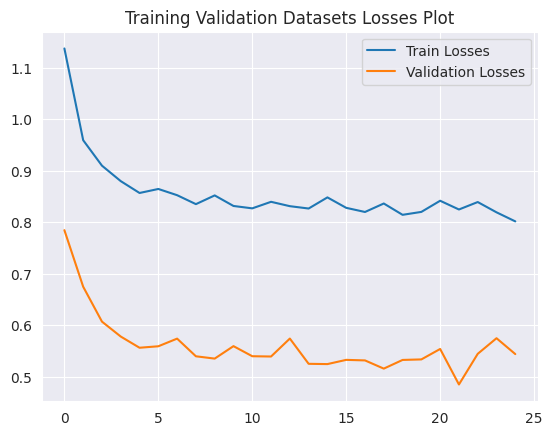

In [ ]:
x=range(len(loss_dict['train_loss']))
sns.lineplot(x=x,y=loss_dict['train_loss'],label="Train Losses");
sns.lineplot(x=x,y=loss_dict['val_loss'],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();

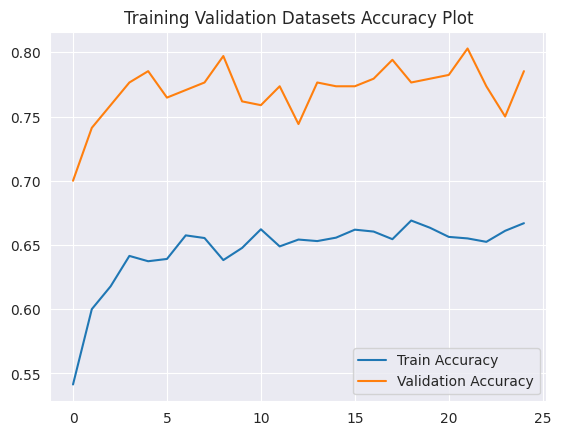

In [ ]:
sns.lineplot(x=x,y=loss_dict['train_acc'],label="Train Accuracy");
sns.lineplot(x=x,y=loss_dict['val_acc'],label="Validation Accuracy");
plt.title("Training Validation Datasets Accuracy Plot");
plt.legend();

# Transfer Learning with Fine Tuning

In [ ]:
model=get_model()
model.load_state_dict(torch.load(extractor_weights_path))

<All keys matched successfully>

In [ ]:
optimizer=optim.Adam(model.parameters(),lr=3e-5,weight_decay=1e-4)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                  patience=7, threshold=0.0001)
loss_fn=nn.CrossEntropyLoss(reduction="sum")
finetuning_weights_path="/content/finetuning_model.pth"

In [ ]:
loss_dict=training(model,50,train_dl,val_dl,optimizer,lr_scheduler,loss_fn,
                   finetuning_weights_path)

Updating Best Model weights
1/50: Training
loss: 0.780279041042407 accuracy: 0.6850207223208999
1/50: Evaluating
loss: 0.4853879962773884 accuracy: 0.8
************************************************** 

Updating Best Model weights
2/50: Training
loss: 0.7105329992363197 accuracy: 0.7060390763765542
2/50: Evaluating
loss: 0.4121213826624786 accuracy: 0.8029411764705883
************************************************** 

Updating Best Model weights
3/50: Training
loss: 0.6836758776308165 accuracy: 0.7214328004736531
3/50: Evaluating
loss: 0.3926493278101963 accuracy: 0.8411764705882353
************************************************** 

4/50: Training
loss: 0.6649876024117478 accuracy: 0.7335701598579041
4/50: Evaluating
loss: 0.39029640347203787 accuracy: 0.8264705882352941
************************************************** 

Updating Best Model weights
5/50: Training
loss: 0.6223532629831787 accuracy: 0.7480757844878626
5/50: Evaluating
loss: 0.3632551543414593 accuracy: 0.84705882

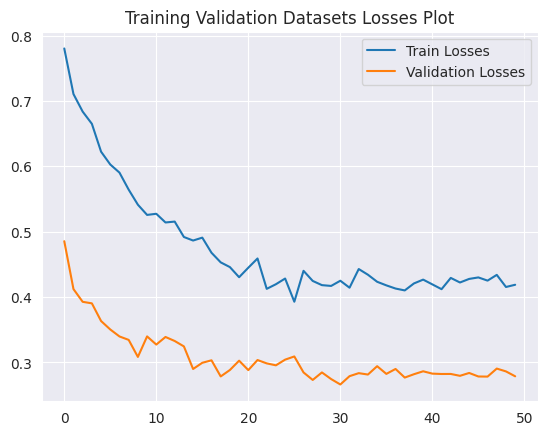

In [ ]:
x=range(len(loss_dict['train_loss']))
sns.lineplot(x=x,y=loss_dict['train_loss'],label="Train Losses");
sns.lineplot(x=x,y=loss_dict['val_loss'],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();

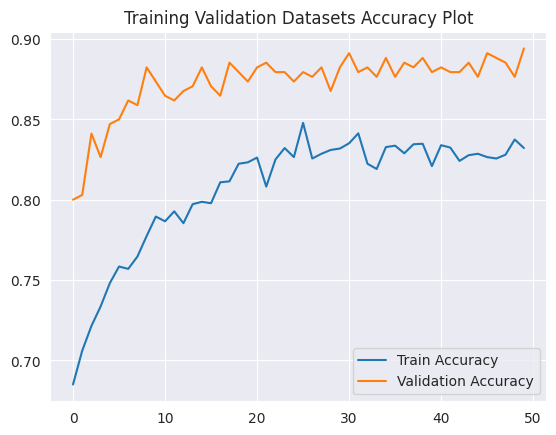

In [ ]:
sns.lineplot(x=x,y=loss_dict['train_acc'],label="Train Accuracy");
sns.lineplot(x=x,y=loss_dict['val_acc'],label="Validation Accuracy");
plt.title("Training Validation Datasets Accuracy Plot");
plt.legend();

# Evaluation

In [ ]:
model=get_model()
model.load_state_dict(torch.load(finetuning_weights_path))

<All keys matched successfully>

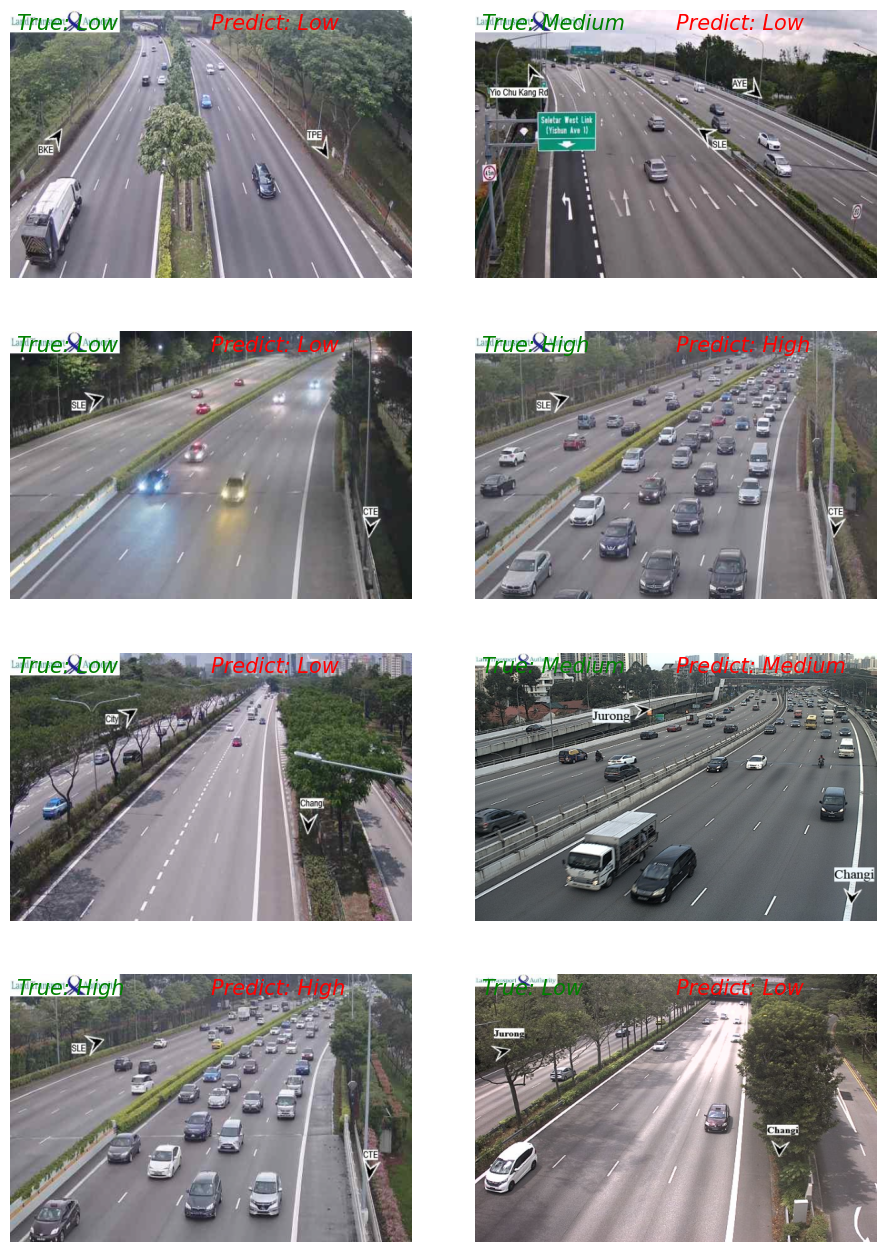

In [ ]:
fig,axes=plt.subplots(4,2,figsize=(12,16))
plt.subplots_adjust(wspace=0)
ax=axes.flatten()

imgs,labels=next(iter(test_dl))
model.eval()
with torch.no_grad():
    imgs=imgs.to(device)
    output=model(imgs)

for i in range(imgs.shape[0]):
    pred_label=output[i].argmax(0)
    ax[i].imshow(imgs[i].permute(1,2,0).cpu().numpy()*std+mean)
    ax[i].text(10,30,"True: "+ classes[labels[i].item()],style ='italic',
               fontsize = 15, color ="green")
    ax[i].text(300,30,"Predict: "+ classes[pred_label.item()],style ='italic',
                fontsize = 15, color ="red")
    ax[i].axis("off")

plt.savefig("6.png");

# Inference

In [ ]:
y_true=[]
y_pred=[]
model.eval()
with torch.no_grad():
    for j,(imgs,labels) in enumerate(test_dl):
        imgs,labels=imgs.to(device),labels.to(device)
        output=model(imgs)
        pred_labels=output.argmax(dim=1)
        y_true+=labels.tolist()
        y_pred+=pred_labels.tolist()

In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97        64
           1       0.89      0.91      0.90        64
           2       0.86      0.89      0.88        64
           3       0.82      0.84      0.83        64
           4       1.00      0.95      0.98        64

    accuracy                           0.91       320
   macro avg       0.91      0.91      0.91       320
weighted avg       0.91      0.91      0.91       320



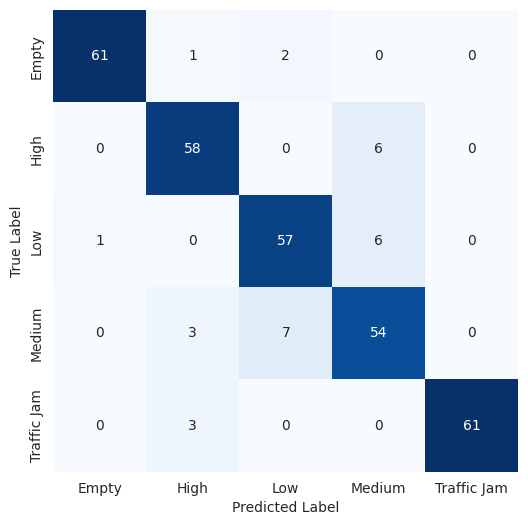

In [ ]:
plt.figure(figsize=(6,6));
val=['Empty', 'High', 'Low', 'Medium', 'Traffic Jam']
plot_data=pd.DataFrame(confusion_matrix(y_true,y_pred),columns=val,index=val)

sns.heatmap(plot_data,annot=True,cbar=False,cmap='Blues',fmt='g');
plt.xlabel('Predicted Label');
plt.ylabel('True Label');
plt.savefig("7.png");